<a href="https://colab.research.google.com/github/apchavezr/19.-Procesamiento-del-Lenguaje-Natural/blob/main/RF_Noticias_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Ejemplo 3. Categorización de noticias con Random Forest (español)

**Objetivo:** clasificar artículos periodísticos en **deportes**, **política** y **cultura** usando **TF-IDF** y **RandomForestClassifier**.  
Se entrenará un modelo, se evaluará con métricas estándar y se visualizará la matriz de confusión y la importancia de términos.



## contenidos y resultados de aprendizaje
1. crear un mini dataset sintético (tres categorías).
2. dividir en *train/test* estratificado.
3. construir un *pipeline* `TfidfVectorizer` + `RandomForestClassifier`.
4. entrenar y evaluar con: **accuracy**, **precision**, **recall**, **F1**.
5. visualizar **matriz de confusión** (matplotlib).
6. analizar **importancia de características** (términos con mayor aporte).
7. ejercicios guiados (n-gramas, `n_estimators`, `max_depth`, balance de clases).


In [1]:

# En Colab: descomente si necesita instalar
# !pip install scikit-learn pandas matplotlib --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



## 1. crear el dataset sintético

Noticias cortas y representativas para **deportes**, **política** y **cultura**. Puede editar o ampliar.


In [2]:

deportes = [
    "la selección colombiana ganó el partido en barranquilla",
    "el equipo consiguió un gol en los últimos minutos",
    "el jugador anunció su traspaso a un club europeo",
    "gran victoria en el torneo nacional de fútbol",
    "el entrenador presentó la convocatoria para la copa",
    "el atleta batió el récord en la competencia",
    "el árbitro expulsó a dos jugadores por falta",
    "el club presentó su nueva camiseta oficial",
    "el clásico terminó en empate sin goles",
    "la liga reprogramó la jornada por lluvia",
]

politica = [
    "el gobierno anunció reformas en el sistema de salud",
    "las elecciones legislativas registraron alta participación",
    "el partido presentó un proyecto de ley sobre educación",
    "el congreso aprobó el presupuesto para el próximo año",
    "la alcaldía firmó convenios de cooperación internacional",
    "el ministro explicó la estrategia de seguridad ciudadana",
    "la oposición criticó la gestión del gabinete",
    "el tribunal constitucional revisará la demanda",
    "la campaña electoral enfocó su mensaje en empleo",
    "el senado debatió la política pública de vivienda",
]

cultura = [
    "el museo inauguró una exposición de arte contemporáneo",
    "la obra de teatro recibió excelentes críticas",
    "el festival de cine presentó estrenos latinoamericanos",
    "un concierto sinfónico cautivó al público en el teatro",
    "la feria del libro reunió a reconocidos autores",
    "la compañía de danza estrenó una coreografía innovadora",
    "el director presentó su nueva película en cartelera",
    "la galería anunció una subasta de arte moderno",
    "un ciclo de poesía convocó a jóvenes escritores",
    "la orquesta interpretó piezas de compositores clásicos",
]

df = pd.DataFrame({
    "texto": deportes + politica + cultura,
    "etiqueta": ["deportes"] * len(deportes) + ["política"] * len(politica) + ["cultura"] * len(cultura)
})
df.sample(6, random_state=0)


,texto,etiqueta
2,el jugador anunció su traspaso a un club europeo,deportes
28,un ciclo de poesía convocó a jóvenes escritores,cultura
13,el congreso aprobó el presupuesto para el próx...,política
10,el gobierno anunció reformas en el sistema de ...,política
26,el director presentó su nueva película en cart...,cultura
24,la feria del libro reunió a reconocidos autores,cultura



## 2. partición entrenamiento/prueba (estratificada)


In [3]:

X_train, X_test, y_train, y_test = train_test_split(
    df["texto"],
    df["etiqueta"],
    test_size=0.3,
    random_state=42,
    stratify=df["etiqueta"]
)
len(X_train), len(X_test), y_train.value_counts(), y_test.value_counts()


(21,
 9,
 etiqueta
 política    7
 cultura     7
 deportes    7
 Name: count, dtype: int64,
 etiqueta
 cultura     3
 política    3
 deportes    3
 Name: count, dtype: int64)


## 3. pipeline TF-IDF + RandomForestClassifier

Hiperparámetros iniciales: `n_estimators=200`, `max_depth=None`, `random_state=42`.  
Puede ajustarlos en los ejercicios para observar el efecto en las métricas.


In [4]:

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2))),
    ("clf", RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1))
])



## 4. entrenamiento y evaluación


In [6]:

pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

acc = accuracy_score(y_test, preds)
cm = confusion_matrix(y_test, preds, labels=["deportes","política","cultura"])
print("Accuracy:", round(acc, 3))
print("\nMatriz de confusión (filas=verdad, columnas=predicción):")
print(pd.DataFrame(cm, index=["deportes","política","cultura"], columns=["deportes","política","cultura"]))

print("\nReporte de clasificación:")
print(classification_report(y_test, preds, target_names=["deportes","política","cultura"]))


Accuracy: 0.333

Matriz de confusión (filas=verdad, columnas=predicción):
          deportes  política  cultura
deportes         1         2        0
política         0         2        1
cultura          2         1        0

Reporte de clasificación:
              precision    recall  f1-score   support

    deportes       0.00      0.00      0.00         3
    política       0.33      0.33      0.33         3
     cultura       0.40      0.67      0.50         3

    accuracy                           0.33         9
   macro avg       0.24      0.33      0.28         9
weighted avg       0.24      0.33      0.28         9




## 5. visualización de la matriz de confusión


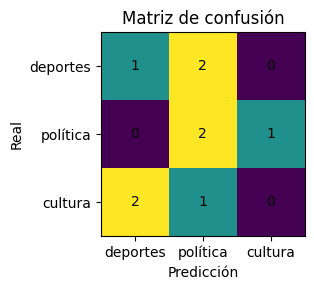

In [7]:

fig = plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión")
plt.xticks([0,1,2], ["deportes","política","cultura"])
plt.yticks([0,1,2], ["deportes","política","cultura"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()



## 6. importancia de características (términos)

Se examinan los términos con mayor **importancia** global según el bosque aleatorio.


In [8]:

# Extraer vectorizador y clasificador entrenados
vectorizer = pipe.named_steps["tfidf"]
clf = pipe.named_steps["clf"]
feature_names = vectorizer.get_feature_names_out()
importancias = clf.feature_importances_

# Top términos globales
idx_top = importancias.argsort()[-20:][::-1]
top_terms = [(feature_names[i], round(importancias[i], 6)) for i in idx_top]
for t, v in top_terms:
    print(f"{t:35s} {v}")


de                                  0.096492
en                                  0.071854
el                                  0.065828
una                                 0.023564
la                                  0.017941
de arte                             0.013085
su                                  0.009976
presentó                            0.009804
estrenos latinoamericanos           0.008189
consiguió                           0.006991
camiseta oficial                    0.006635
su nueva                            0.00634
para el                             0.006226
festival de                         0.006166
nueva camiseta                      0.006138
criticó la                          0.006019
gobierno                            0.005966
para                                0.005888
un                                  0.005851
el récord                           0.005761



## 7. predicciones sobre nuevas noticias


In [9]:

nuevos = [
    "la selección ganó el campeonato con dos goles",
    "el congreso debatió la reforma política",
    "el museo presentó una retrospectiva del artista",
    "jugadores y entrenador hablaron del clásico bogotano",
    "la campaña prometió mejorar el sistema de transporte"
]
for t in nuevos:
    print(f"- {t} -> {pipe.predict([t])[0]}")


- la selección ganó el campeonato con dos goles -> deportes
- el congreso debatió la reforma política -> política
- el museo presentó una retrospectiva del artista -> cultura
- jugadores y entrenador hablaron del clásico bogotano -> política
- la campaña prometió mejorar el sistema de transporte -> cultura



## 8. ejercicios guiados

1. **n-gramas:** cambie `ngram_range=(1,2)` por `(1,1)` y luego `(1,3)`. Compare métricas.
2. **árboles:** pruebe `n_estimators=100`, `300` y `500`. Observe el tiempo de entrenamiento y el *accuracy*.
3. **profundidad:** limite `max_depth` a `10`, `20` y `30`. Analice sobreajuste vs. generalización.
4. **balance:** si desbalancea el corpus (p. ej., más noticias de política), evalúe `class_weight="balanced"`.
5. **palabras clave:** añada términos más específicos por categoría (p. ej., “tarjeta roja”, “cámara de representantes”, “bienal”). ¿Mejora el rendimiento?
6. **temas cercanos:** integre una cuarta clase (p. ej., *economía*) y verifique confusiones con política.
